## Regression

The 'term' regression differs in common usage between econometrics and machine learning. In econometrics, a regression invloves the estimation of parameters values that relate a dependent variable to independents variables.<br>
The most common form of regression in econometrics is multiple linear regression, which involves the estimation of a linear association between a continuos dependent variable and multiple independent variables.


### Linear Regression

#### Overview

A linear regression models the relationship between a dependent variable, y, and a set of independent variables, under the assupmtion of linearity in the coefficients.[1]

[1] : *There will not be a deterministic relationship between the dependent variable and independent variables, Rather, ther wil be some noise ε associated with each observation, which could arise as the result of unobserved, random differences across entities or measurement error.*


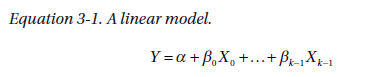



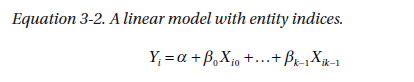

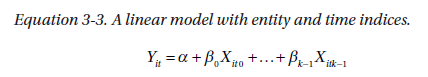

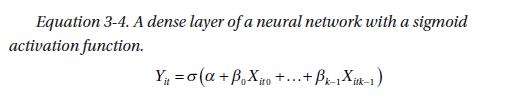

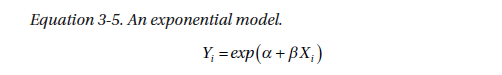

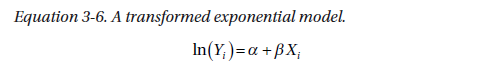

As an example of this, let's say we have data drawn from a process that is known to be non-linear, but its exact functional form in unknown. <br>
Figure 3_1 shows a scatter plot of the data, along with plots of two linear regression model.<br>
<br>

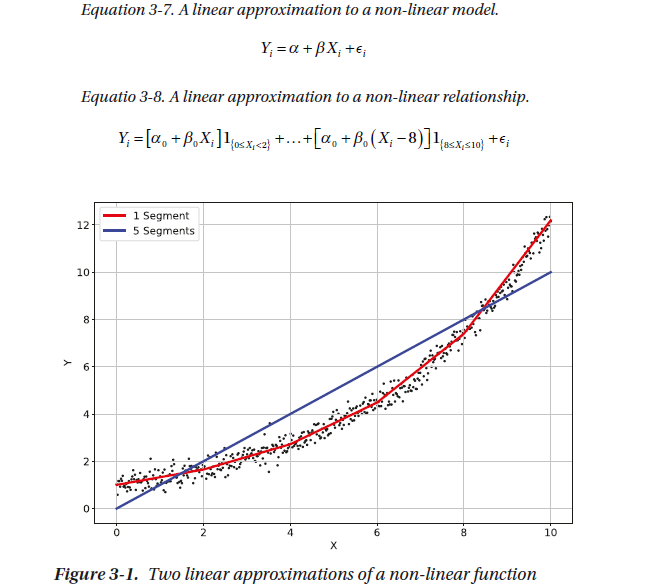

The first is trained over the assumption that the relationship  between X and Y is well aproximatted over an interval using a single line.

The second one takes the assumption that we need 5 segment lines like in equation 3-8

#### Ordinary Least Squares (OLS)

In economics the most common loss function is the sum or mean of the squared errors[2], which we will consider first.

[2] *'mse' is the abbreviated name used in TensorFlow*